<a href="https://www.kaggle.com/code/maksimlarin/notebookc132224234/edit">Мой notebook на kaggle c этой работой</a>

                                                                    
# Определение стоимости автомобилей

# Цель

Для сервиса не «Не бит, не крашен» разработать модель для определения рыночной стоимости автомобиля<br>
Модель будет использована в приложении с целью привлечения новых клиентов<br> 



Заказчику важны:<br>

- качество предсказания<br>
- скорость предсказания<br>
- время обучения<br>

Данные хранятся в файле https://code.s3.yandex.net/datasets/autos.csv<br>

Признаки<br>
- DateCrawled — дата скачивания анкеты из базы<br>
- VehicleType — тип автомобильного кузова<br>
- RegistrationYear — год регистрации автомобиля<br>
- Gearbox — тип коробки передач<br>
- Power — мощность (л. с.)<br>
- Model — модель автомобиля<br>
- Kilometer — пробег (км)<br>
- RegistrationMonth — месяц регистрации автомобиля<br>
- FuelType — тип топлива<br>
- Brand — марка автомобиля<br>
- Repaired — была машина в ремонте или нет<br>
- DateCreated — дата создания анкеты<br>
- NumberOfPictures — количество фотографий автомобиля<br>
- PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
- LastSeen — дата последней активности пользователя<br>

Целевой признак<br>
- Price — цена (евро)<br>


Для оценки качества модели использовать метрику RMSE<br>
Значение метрики должно быть меньше 2500<br>
<br>
Для оптимизации модели построить градиентный бустинг средствами библиотеки LightGBM<br>

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from optuna.integration import LightGBMPruningCallback
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [4]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [5]:
try:
    import phik
    from phik.report import plot_correlation_matrix
    from phik import report
    import optuna
except:
    %pip install phik
    %pip install optuna
    
import phik
import optuna

In [6]:
try:
    data = pd.read_csv('autos.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
  

In [7]:
# зададим константы
NAME_DATA = 'autos.csv'
RANDOM_STATE = 6568

In [8]:
def isna_count_procent(data, name):
    '''
    Создадим таблицу с пропусками в  дата сете
    Всего три столбца 
    1. процентное отношение пропусков к длине
    2. количество пропусков в единицах
    3. тип
    Далее блок выводит всю доступную информацию о данных 
    Несколько первых строк
    Описание числовых признаков
    Описание категориальных признаков
    
    '''
    isna_columns = data.isna().sum() > 0
    type_ = pd.DataFrame(data[data.isna().sum()[isna_columns].index.tolist()].dtypes)[0]
    isna_columns = pd.DataFrame([data.isna().sum()[isna_columns]/data.shape[0], data.isna().sum()[isna_columns]]).T
    isna_columns = isna_columns.rename(columns={0: 'procent', 1: 'count'})
    isna_columns['type'] = type_[0]
    isna_columns['count'] = isna_columns['count'].map('{:,.2f}'.format)
    isna_columns['procent'] = isna_columns['procent'].map('{:,.2%}'.format)
    isna_columns = isna_columns.sort_values('procent', ascending=False)
    # блок показывае всё о данных
    display(data.head(5))
    print('#'*55)
    print()
    display(data.describe(include=np.number))
    print()
    display(data.describe(include=np.object_))
    print('#'*55)
    print()
    data.info()
    print('#'*55)
    isna = data.isna().sum().sum()
    isna_procent = len(isna_columns)/data.shape[1]
    s = data.duplicated().sum()
    print(f'Количество дубликатов в данных  равно {s}')
    print()
    print(f'Всего пропусков в {name} {isna:,} шт. в {len(isna_columns)} столбцах')
    print(f'В процентном отношении {isna_procent:.2%} от {data.shape[1]:,} признаков')
  
    print()
    return display(isna_columns), pd.set_option('display.max_rows', None)

In [9]:
isna_count_procent(data, 'autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#######################################################



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


#######################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen   

,procent,count,type
FuelType,9.28%,"32,895.00",object
Gearbox,5.60%,"19,833.00",object
Model,5.56%,"19,705.00",object
Repaired,20.08%,"71,154.00",object
VehicleType,10.58%,"37,490.00",object


(None, None)

Представлен табличный формат размером 354,369 объектов с 16 признаками<br>
Большое количество пропусков, 181,077 шт. в 5 столбцах все категориального типа `object`<br>
Три столбца подходят для формата DataTame – DateCrawled, DateCreated, LastSeen <br>
Но не в одном из них количество объектов не соответствует уникальным, надо проверить и определить наиболее подходящий<br>

В числовых данных пропусков нет, но присутствуют выбросы как например в столбцах `Power`,  `Price` есть значения равные `0`<br>
В признаке `RegistrationYear` присутствуют значения `1000 и 9999` что явно свидетельствует об ошибках в данных<br>
Есть 4 полных дубликата которые мы удалим незамедлительно<br>
Признак `numberofpictures`, понулям все строки, удалим его

In [10]:
# удалим дубоикаты в данных
data = data.drop_duplicates().reset_index(drop=True)

s = data.duplicated().sum()
print(f'Количество дубликатов в данных  равно {s}')
print(f'Количество строк insurance.csv после удаления дубликатов {data.shape[0]:,}')

Количество дубликатов в данных  равно 0
Количество строк insurance.csv после удаления дубликатов 354,365


In [11]:
# поправим названия признаков 
data.columns = data.columns.str.lower() 
pd.DataFrame(data.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen


In [12]:
data = data.drop(columns=['numberofpictures'], axis=1)

определимся с признаком дата

In [13]:
display(data[['datecrawled', 'datecreated', 'lastseen']].describe(include=np.object_))

,datecrawled,datecreated,lastseen
count,354365,354365,354365
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13718,17


Все признаки приведём к формату `datatime`


In [14]:
data['datecrawled'] = pd.DatetimeIndex(data['datecrawled'])
data['datecreated'] = pd.DatetimeIndex(data['datecreated'])
data['lastseen'] = pd.DatetimeIndex(data['lastseen'])

Создадим списки с признаками отсортированными по типу

In [15]:
object_columns = data.select_dtypes(object).columns.to_list()
int64_columns  = [x for x in data.columns if data[x].dtypes == 'int64' and data[x].mean() != 0]
int64_columns.sort(key='price'.__eq__)

Поспотрим как стоимость разбросана по времени

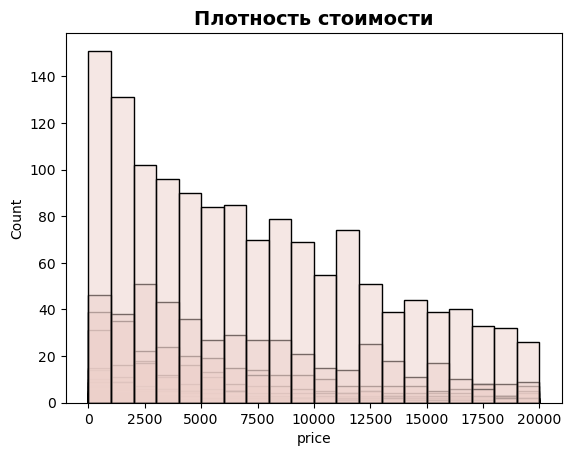

In [16]:
datecrawled_exam = data.groupby('price')['datecrawled'].agg('count').reset_index().sort_values(by='datecrawled').copy()
sns.histplot(data = datecrawled_exam, hue='datecrawled', x='price', bins=20, linewidth=1, legend=False) \
    .set_title(f'Плотность стоимости', dict(fontweight='bold', fontsize=14));


Всё логично большее количество по времени размещали объявления с меньшей стоимостью и по мере увеличения стоимости<br>
Количество уменьшается)

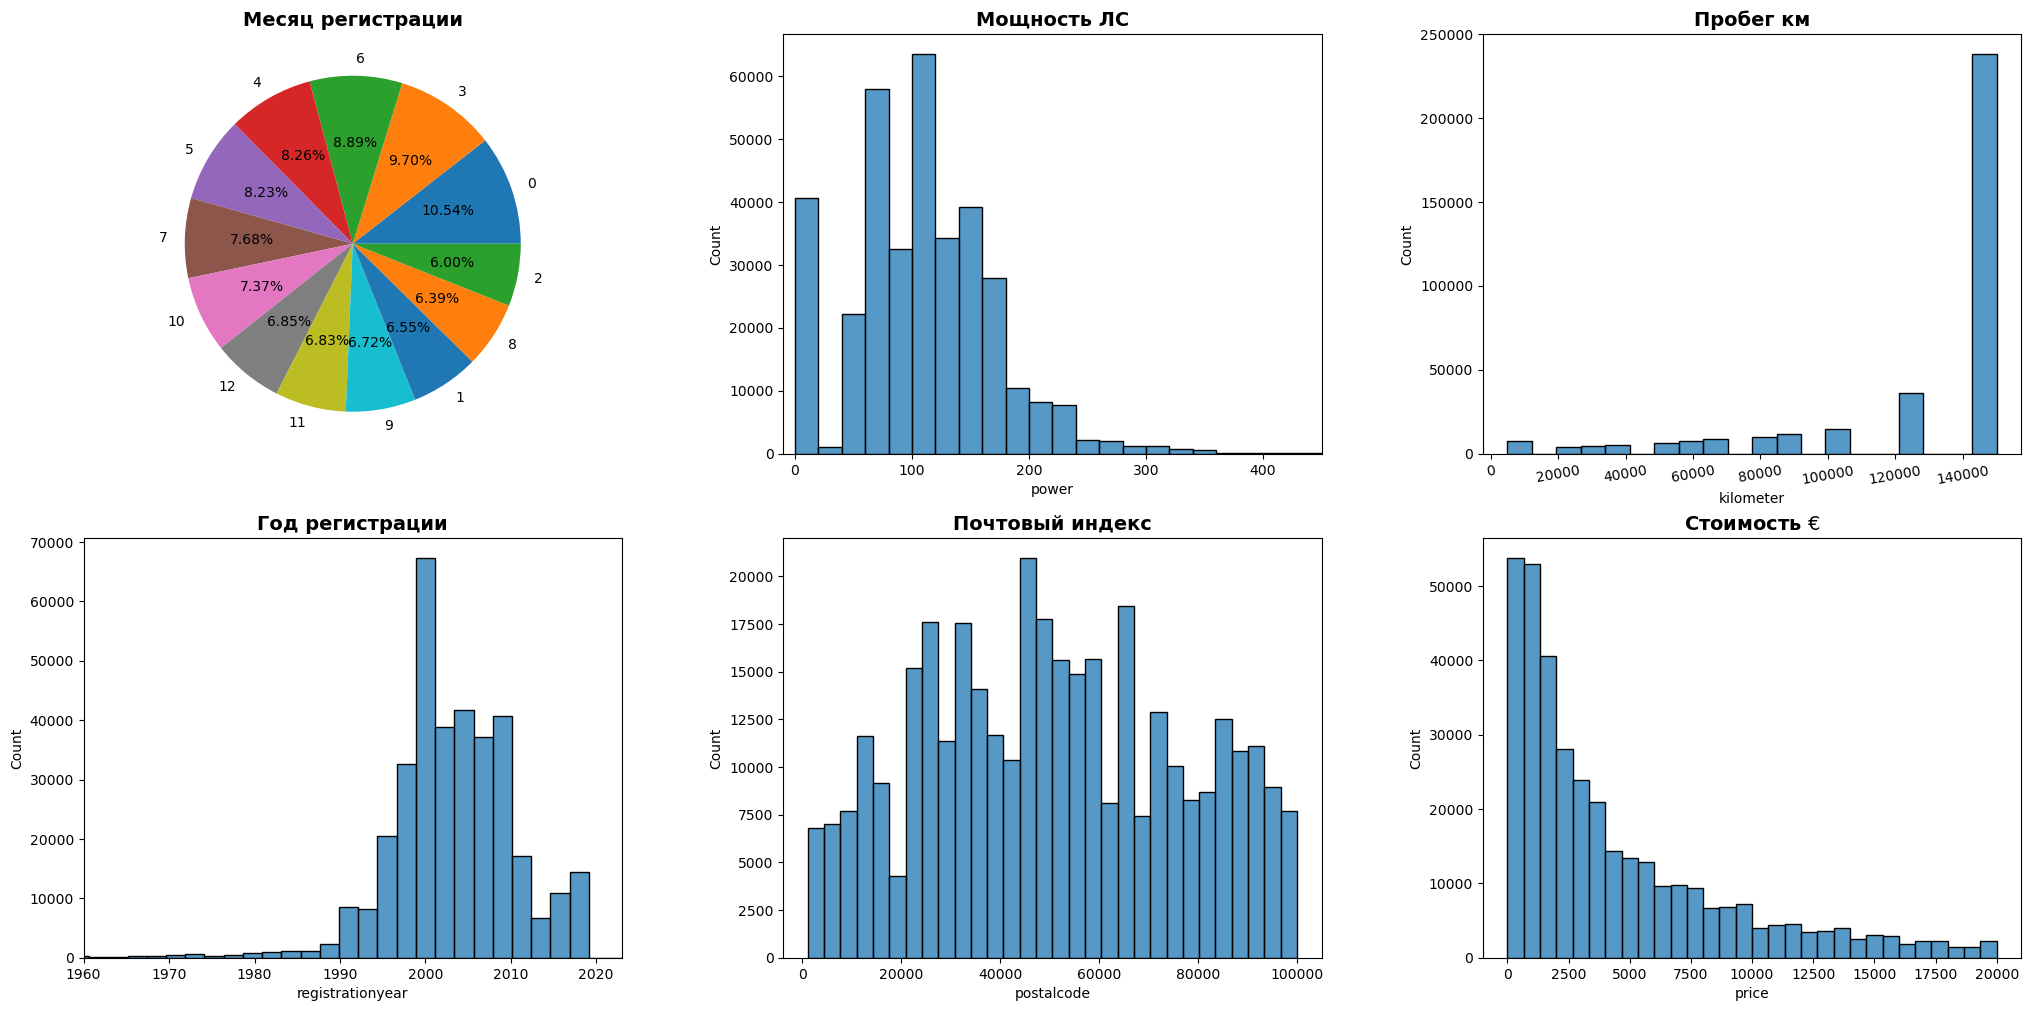

In [17]:
# функция гистограммы данных

def data_hist(data, name_data):
    fig, ((ax, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(25, 12))
    plt.subplots_adjust(wspace=0.3)
    data['registrationmonth'].value_counts().plot.pie( ylabel='', autopct='%1.2f%%', legend=False, ax=ax);
    sns.histplot(data = data['power'], edgecolor='black', bins=1000, linewidth=1, ax=ax1);
    sns.histplot(data = data['kilometer'], edgecolor='black', bins=20, linewidth=1, ax=ax2);
    sns.histplot(data = data['registrationyear'], edgecolor='black', bins=4000, linewidth=1, ax=ax3);
    sns.histplot(data = data['postalcode'], edgecolor='black', bins=30, linewidth=1, ax=ax4);
    sns.histplot(data = data['price'], edgecolor='black', bins=30, linewidth=1, ax=ax5);

    ax3.set_xlim(1960,2023)
    ax1.set_xlim(-10,450)
    ax3.set_title(f'Год регистрации', dict(fontweight='bold', fontsize=14));
    ax1.set_title(f'Мощность ЛС', dict(fontweight='bold', fontsize=14));
    ax2.set_title(f'Пробег км', dict(fontweight='bold', fontsize=14));
    ax.set_title(f'Месяц регистрации', dict(fontweight='bold', fontsize=14));
    ax4.set_title(f'Почтовый индекс', dict(fontweight='bold', fontsize=14));
    ax5.set_title(f'Стоимость $€$', dict(fontweight='bold', fontsize=14));
    ax2.tick_params(axis='x', labelrotation=10)
    plt.show()
data_hist(data[int64_columns], 'int64')

В признаке `power` и `registrationmonth` есть нулевые значения<br>
Распределения со сдвигами и несколькими пиками  `registrationyear`, `postalcode`<br>
Признак `price` имеет распределение с левым обрывом<br>

In [18]:
print('Объектов с мощьностью меньше 50 л.с.', (data['power'] < 50).sum())
print('Из них равных нулю ', (data['power'] == 0).sum())

Объектов с мощьностью меньше 50 л.с. 46172
Из них равных нулю  40225


Признак `power` богат объектами с мощностью меньше 50 л.с. это явная ошибка<br>
Заполним эти объекты средним <br>
Поскольку только в признаке `brand` нет пропусков будим считать среднюю группируя по нему <br>

In [19]:
result =  data.copy()
result['power'] = result['power'].replace({val: np.nan for val in data['power'] if val < 50})
result['power'] = result.groupby(['brand'])['power'].transform(lambda x: x.fillna(x.mean()).astype(int))

In [20]:
print('Количество numpy.nan пропусков после заполнения =',result['power'].isna().sum())

Количество numpy.nan пропусков после заполнения = 0


Построим гистограмму и boxplot графики до и после заполнения для оценки качества заполнения признака `power`<br>







In [25]:
def hist_box(data, column):
    fig, (ax, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(18, 4))
    fig.subplots_adjust(wspace=0.4)
    data.groupby(['brand', 'model', ])[column].agg('mean').plot(kind='hist', bins=40, ax=ax)
    data.groupby(['brand', 'model', ])[column].agg('mean').plot(kind='box',  ax=ax1)

    result.groupby(['brand', 'model'])[column].agg('mean').plot(kind='hist', bins=40, ax=ax2)
    result.groupby(['brand', 'model'])[column].agg('mean').plot(kind='box',  ax=ax3)

    fig.text(0.2, 1, f'Сравниваем изменение в признаке {column.upper()} до и после заполнения', dict(fontweight='bold', fontsize=16))
    ax.set_title(f'{column} гистограмма до', dict(fontweight='bold', fontsize=14))
    ax.set_xlabel(f'{column}')
    ax.set_ylabel(f'brand + model')
    ax1.set_title(f'{column} boxplot до', dict(fontweight='bold', fontsize=14))
    ax2.set_title(f'{column} гистограмма после', dict(fontweight='bold', fontsize=14))
    ax2.set_xlabel(f'{column}')
    ax2.set_ylabel(f'brand + model')
    ax3.set_title(f'{column} boxplot после', dict(fontweight='bold', fontsize=14))
    

plt.show()

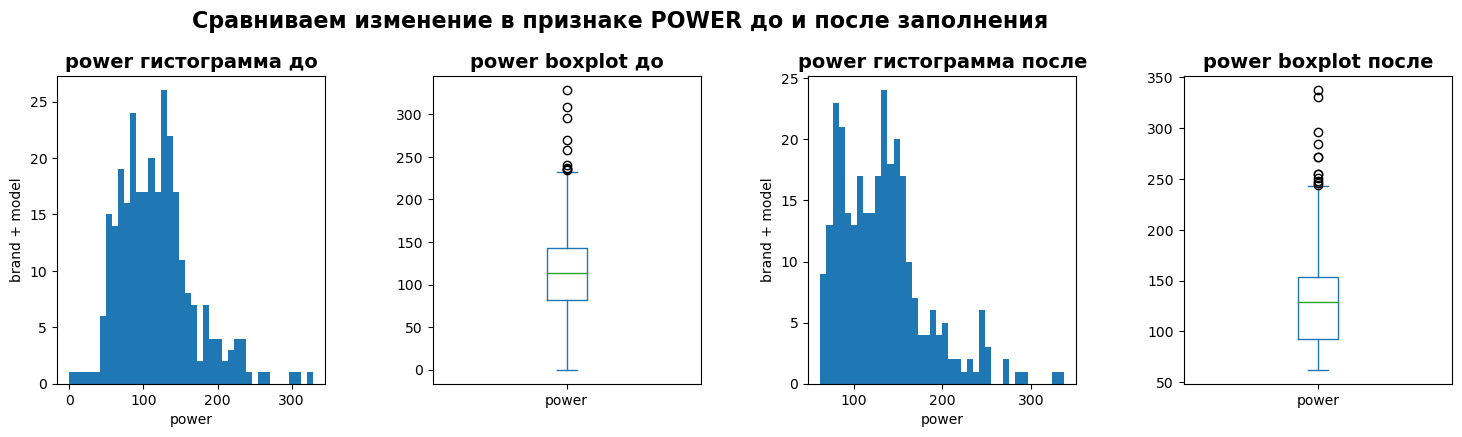

In [26]:
hist_box(data, 'power')

Мы заполнили нулевые значения признака `power` средним значением агрегированным по признаку `brand`<br>
Сравнения гистограммы и boxplot графиков до и после заполнения подтверждают, что данные заполнены корректно<br>
С максимальным сохранением изначального распределения <br>




In [22]:
data = result

В признаке `price` есть значения равные нулю посмотрим на них<br>
И меньше 100 евро

In [23]:
(data['price'] == 0).sum()

10772

In [24]:
(data['price'] < 100).sum()

13314

Заполним их средним значение агрегированным по бренду

In [25]:
result =  data.copy()
result['price'] = result['price'].replace({val: np.nan for val in data['price'] if val < 100})
result['price'] = result.groupby(['brand'])['price'].transform(lambda x: x.fillna(x.mean()).astype(int))

In [26]:
print('Количество numpy.nan пропусков после заполнения =',result['price'].isna().sum())

Количество numpy.nan пропусков после заполнения = 0


Построим гистограмму и boxplot графики до и после заполнения для оценки качества заполнения признака `price`<br>


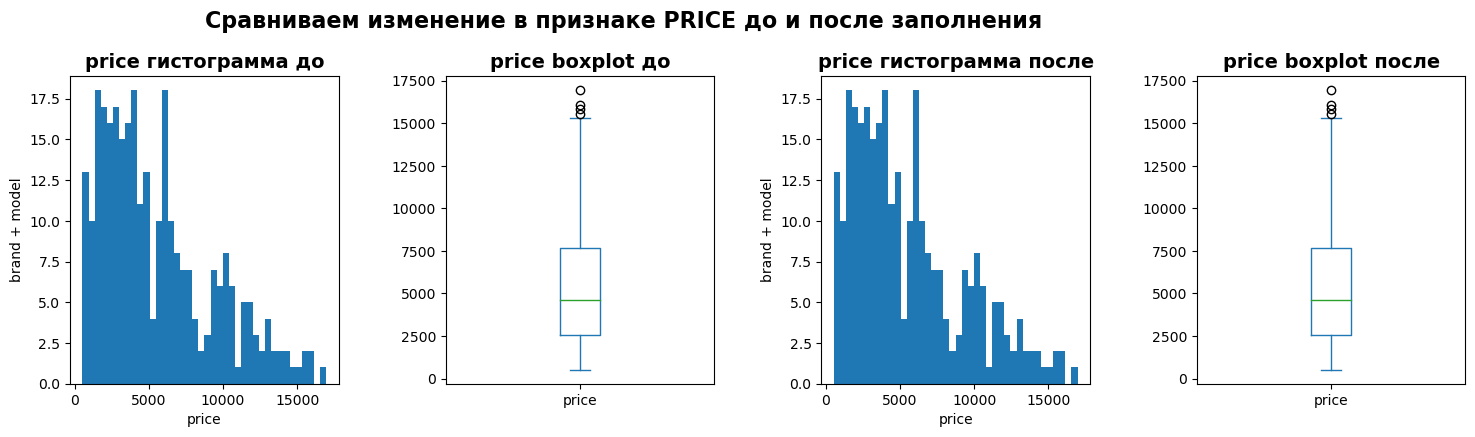

In [27]:
hist_box(data, 'price')

Визуально распределение средней цены сгруппированной по модели и марки изменилось не значительно<br>
Средняя немного увеличилась, что мы ожидали заполнение, выполнено корректно

Удалим все выбросы в числовых данных используя размах ящика с усами
Напишим функцию

In [28]:
data = result

In [29]:
def cut_crap(data, columns):
    q1 = data[columns].quantile(0.25)
    q3 = data[columns].quantile(0.75)
    min_ = q1-(1.5*(q3-q1))
    max_ = q3+(1.5*(q3-q1))
    data = data[~((data[columns] < min_) | (data[columns] > max_)).any(axis=1)]
    return data

Построим график и посмотрим на выбросы в числовых признаках используя ящик с усами

In [30]:
def box_mustache(data, columns):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.boxplot(data[columns], labels=columns)
    ax.set_title('График ящик с усами числовых признаков', dict(fontweight='bold', fontsize=15))
    plt.show()

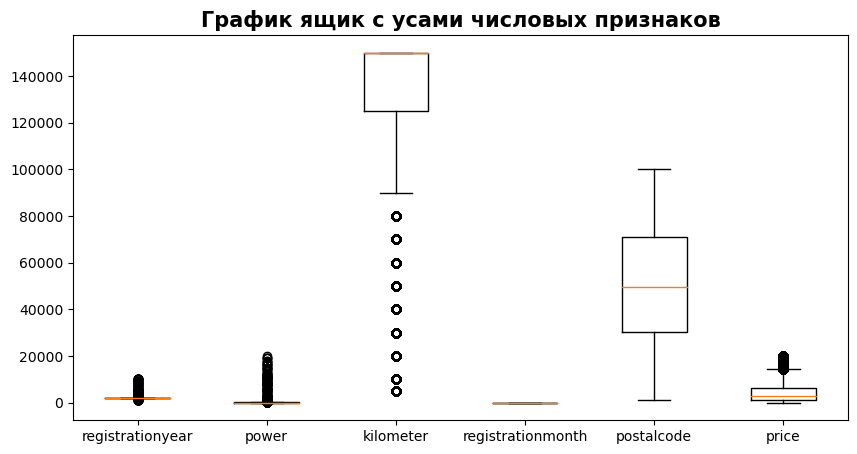

In [31]:
box_mustache(data, int64_columns)

Выбросы есть в четырёх признаках

In [32]:
data.shape

(354365, 15)

In [33]:
number_list = ['registrationyear', 'power',  'kilometer', 'price']
data = cut_crap(data,  number_list)

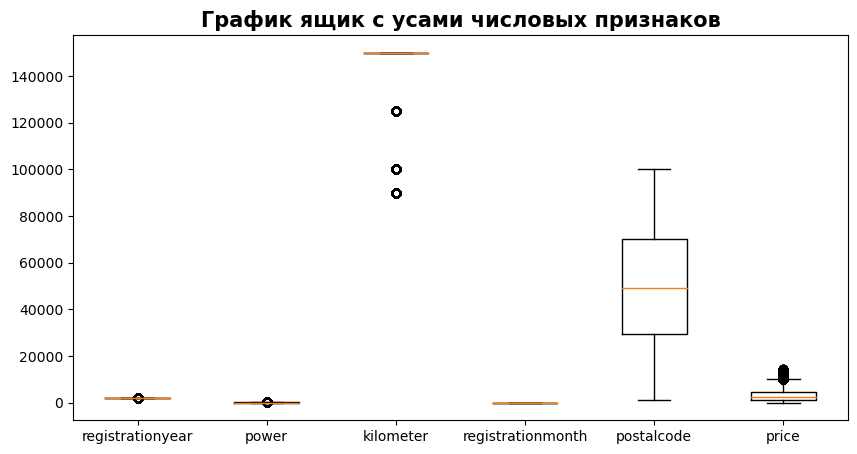

,registrationyear,power,kilometer,registrationmonth,postalcode,price
count,281953.000000,281953.000000,281953.000000,281953.000000,281953.000000,281953.000000
mean,2002.703060,116.661710,142662.269953,5.703720,50263.492415,3432.936149
std,6.114641,41.762309,16138.263777,3.740799,25650.599996,3090.749284
min,1986.000000,50.000000,90000.000000,0.000000,1067.000000,100.000000
25%,1999.000000,86.000000,150000.000000,3.000000,29664.000000,1099.000000
50%,2002.000000,108.000000,150000.000000,6.000000,49090.000000,2400.000000
75%,2006.000000,143.000000,150000.000000,9.000000,70376.000000,4800.000000
max,2019.000000,246.000000,150000.000000,12.000000,99998.000000,14295.000000


In [34]:
box_mustache(data, int64_columns)
display(data[int64_columns].describe())

Убрали выбросы, заполнили нулевые и малые значения средним<br>
Посмотрим на признак `registrationmonth` в нём есть нулевое значение, что так же ошибка<br>
Соотнесём влияние месяца регистрации автомобиля на стоимость<br>


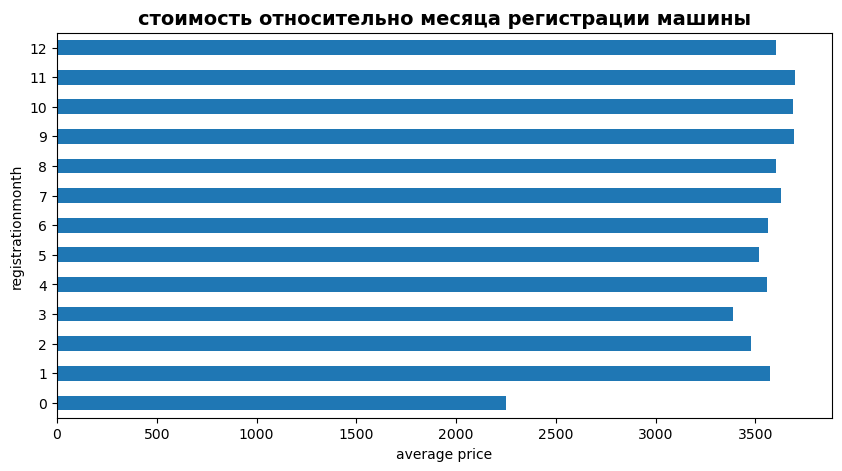

In [35]:
# стоимость и ремонт
fig, ax = plt.subplots(figsize=(12, 8))
data.groupby('registrationmonth')['price'].agg('mean') \
    .plot(kind='barh',  align='center', figsize=(10,5)) \
    .set_title('стоимость относительно месяца регистрации машины', dict(fontweight='bold', fontsize=14));
ax.set_xlabel('average price');

Видим, что месяц регистрации автомобиля сильно не влияет на стоимость<br>
Разница существует, но не значительная <br>
Потенциально рассматриваем этот признак возможным для удаления<br>





Посмотрим на корреляцию числовых признаков с ценой



In [36]:
def corr_psk(data):
    fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(26, 12))

    sns.heatmap(data=data.corr(), annot=True, ax=ax) \
        .set_title('Корреляция Пирсона', weight='bold', size='large');
    sns.heatmap(data=data.corr(method='spearman'), annot=True, ax=ax1) \
        .set_title('Корреляция Спирмена', weight='bold', size='large');
    sns.heatmap(data=data.corr(method='kendall'), annot=True, ax=ax2) \
        .set_title('Корреляция Кенделла', weight='bold', size='large');
    sns.heatmap(data=data.phik_matrix(interval_cols=data.columns), annot=True, ax=ax3) \
        .set_title('Корреляция $\phi_K$', weight='bold', size='large');

    plt.show()

/Users/maximlarin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


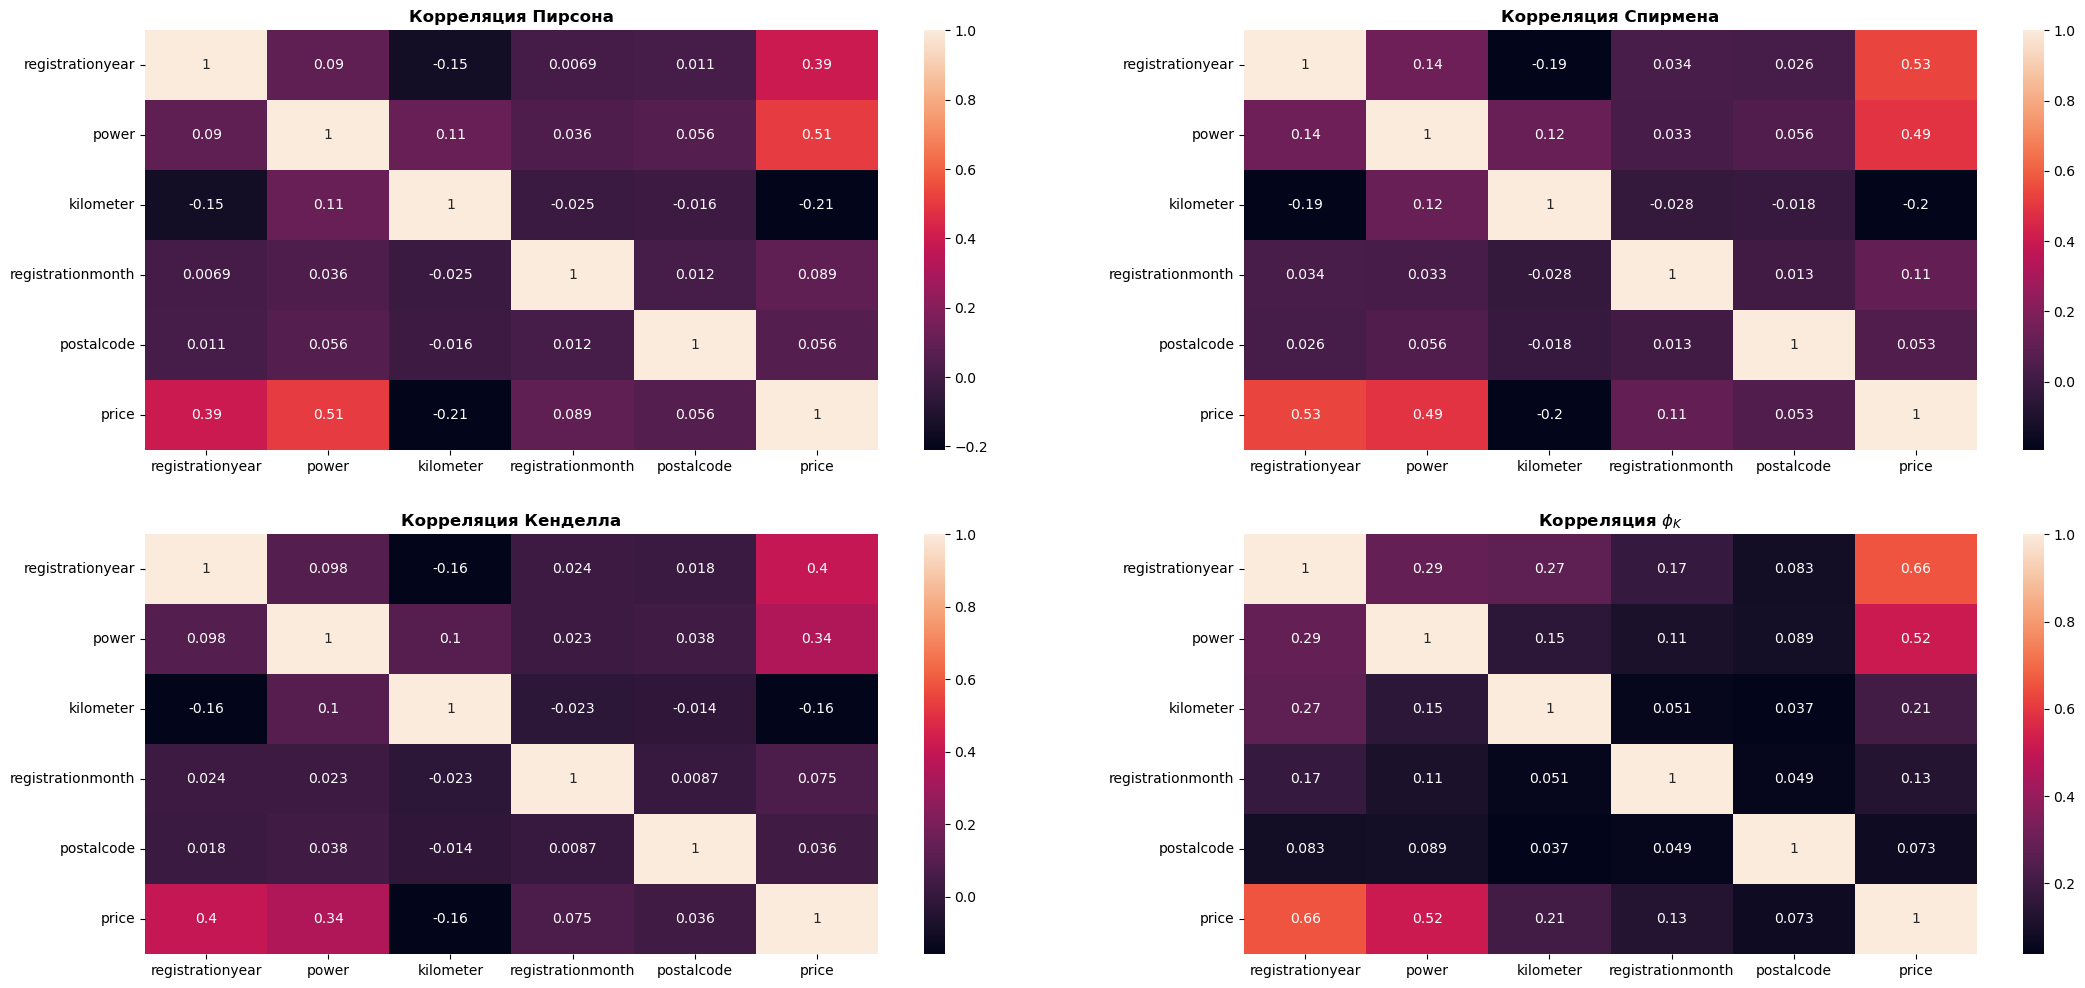

In [37]:
corr_psk(data[int64_columns])

Рассматриваем корреляцию признаков с целевым признаком `price` по трём основным методам кроме $\phi_K$<br>
<br>
Видим корреляцию средней силы по Спирмену у признаков `registrationyear` `power` <br>
Корреляция Пирсона и Кендала у признаков `registrationyear` `power` слабая<br>
Свяь признака `registrationmonth` и `price` на всех схемах очень слабая<br>
Признак `kilometer` на всех схемах имеет слабую обратную корреляцию, всё логично, больше километраж меньше цена<br>
Признак `postalcode` имеет очень слабую корреляцию на всех графиках, рассматриваем его как претендента на удаление<br>


Посмотрим на scater plot графике как коррелирует целевая переменная и числовые признаки

In [38]:
exam_sample = data.sample(frac=0.1, replace=True, random_state=RANDOM_STATE)
exam_sample.shape

(28195, 15)

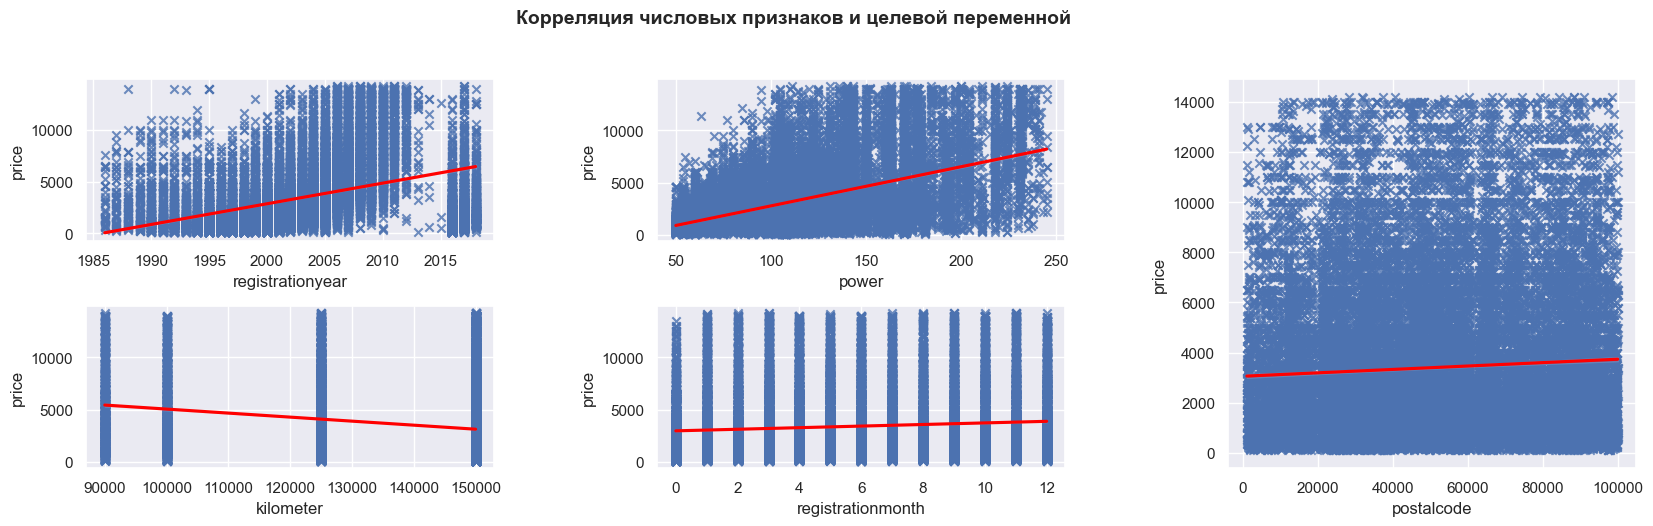

In [39]:
# скаттер плот корреляции целевого признака с признаками
sns.set_theme()
fig = plt.figure(figsize=(20,8))
ax = plt.subplot2grid((3, 3), (0, 0))
ax1 = plt.subplot2grid((3, 3), (0, 1))
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)
fig.text(0.34, 0.95,'Корреляция числовых признаков и целевой переменной', dict(fontweight='bold', fontsize=14))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.regplot(data=exam_sample, x='registrationyear', y='price', ax=ax, line_kws={'color':'red'}, marker='x')
sns.regplot(data=exam_sample, x='power', y='price', ax=ax1, line_kws={'color':'red'}, marker='x')
sns.regplot(data=exam_sample, x='kilometer', y='price', ax=ax2, line_kws={'color':'red'}, marker='x')
sns.regplot(data=exam_sample, x='registrationmonth', y='price', ax=ax3, line_kws={'color':'red'}, marker='x')
sns.regplot(data=exam_sample, x='postalcode', y='price', ax=ax4, line_kws={'color':'red'}, marker='x')

plt.show()

Видим, что как предполагали ранее признак `registrationmonth` демонстрирует отсутствие связи с `price` <br>
Признак `postalcode` изменяется не значительно можем им пренебречь <br>
Удалим эти признаки


In [40]:
data = data.drop(columns=['registrationmonth', 'postalcode'], axis=1)
for i in ['registrationmonth', 'postalcode']:
    int64_columns.remove(i)

### посмотрим категориальные признаки

 категориальный признак признаак  `brand` и `model`

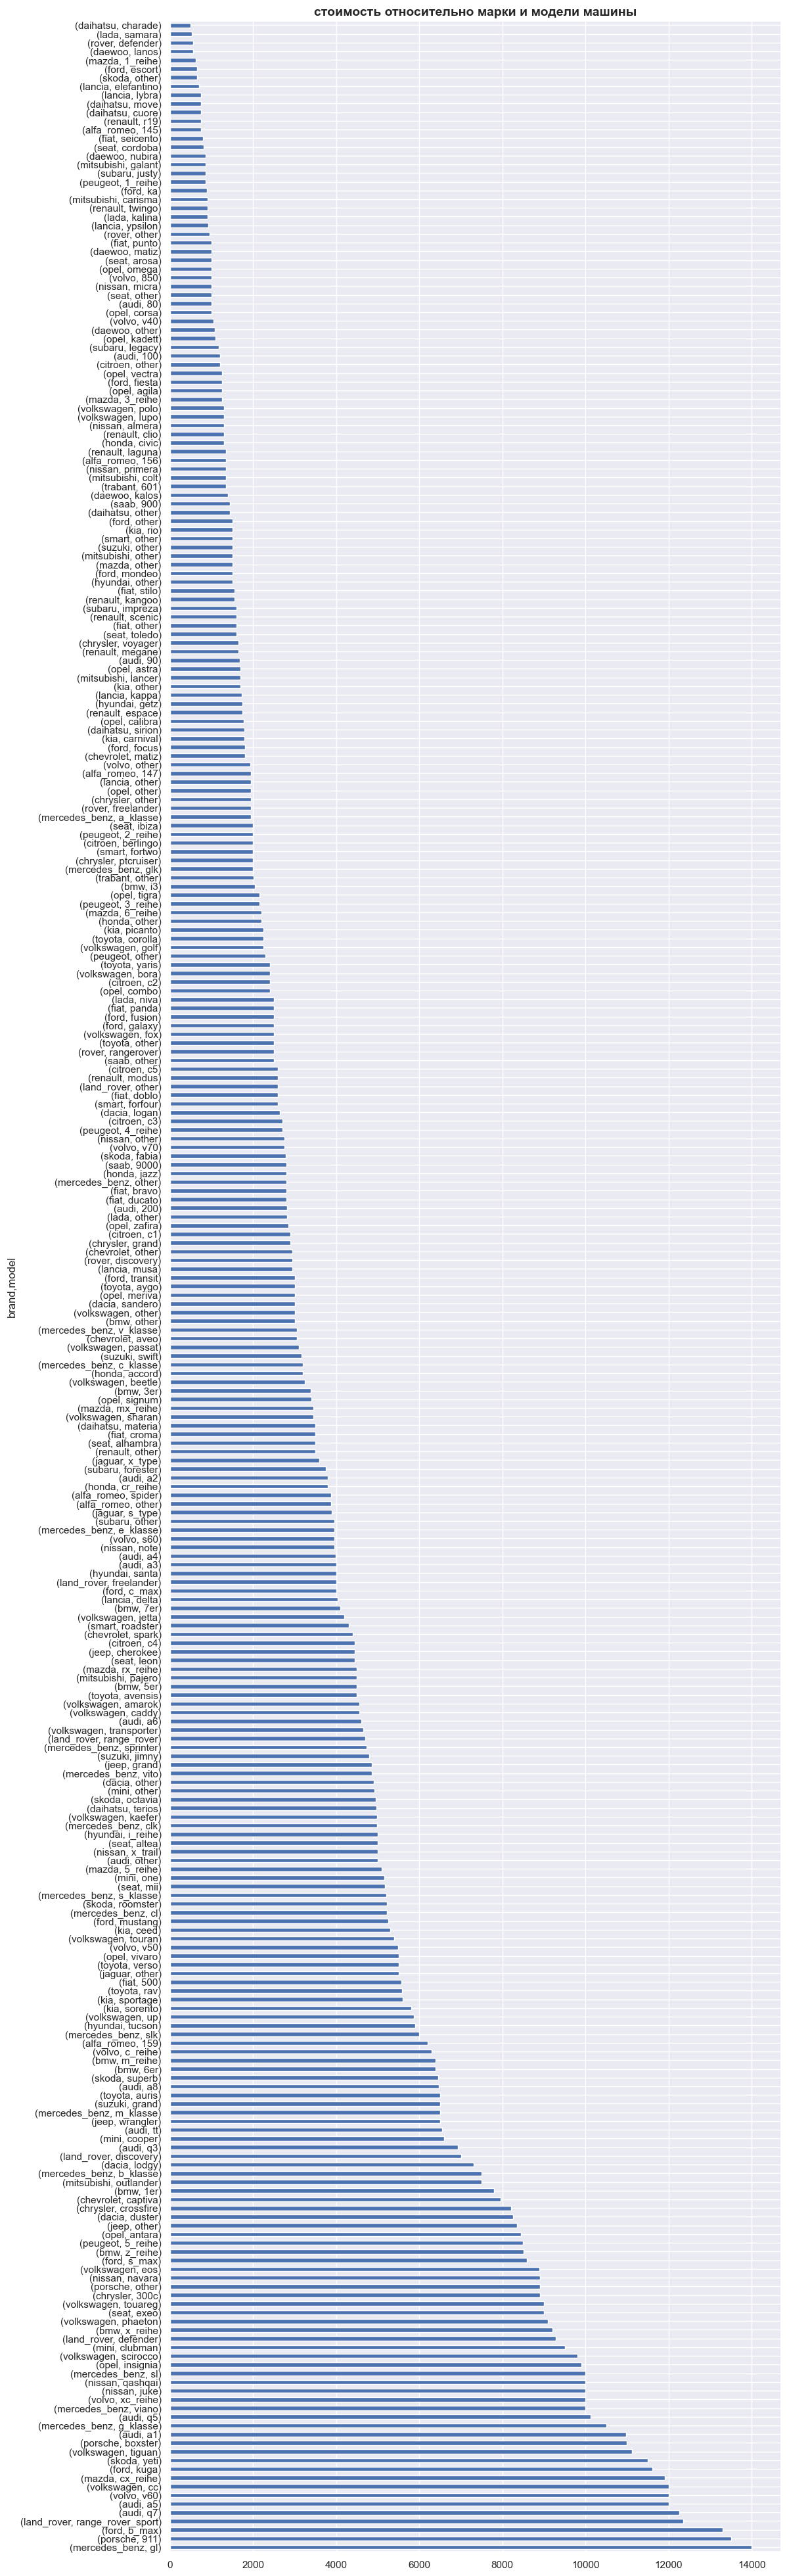

In [41]:
brand_exam = data.groupby(['brand', 'model'])['price'].agg('median') \
    .sort_values(ascending=False).plot(kind='barh',  align='center', figsize=(12,50)) \
    .set_title('стоимость относительно марки и модели машины', dict(fontweight='bold', fontsize=14));

Видим, что цена зависит как от марки так и от модели автомобиля<br>
посмотрим на остальные категориальные признаки

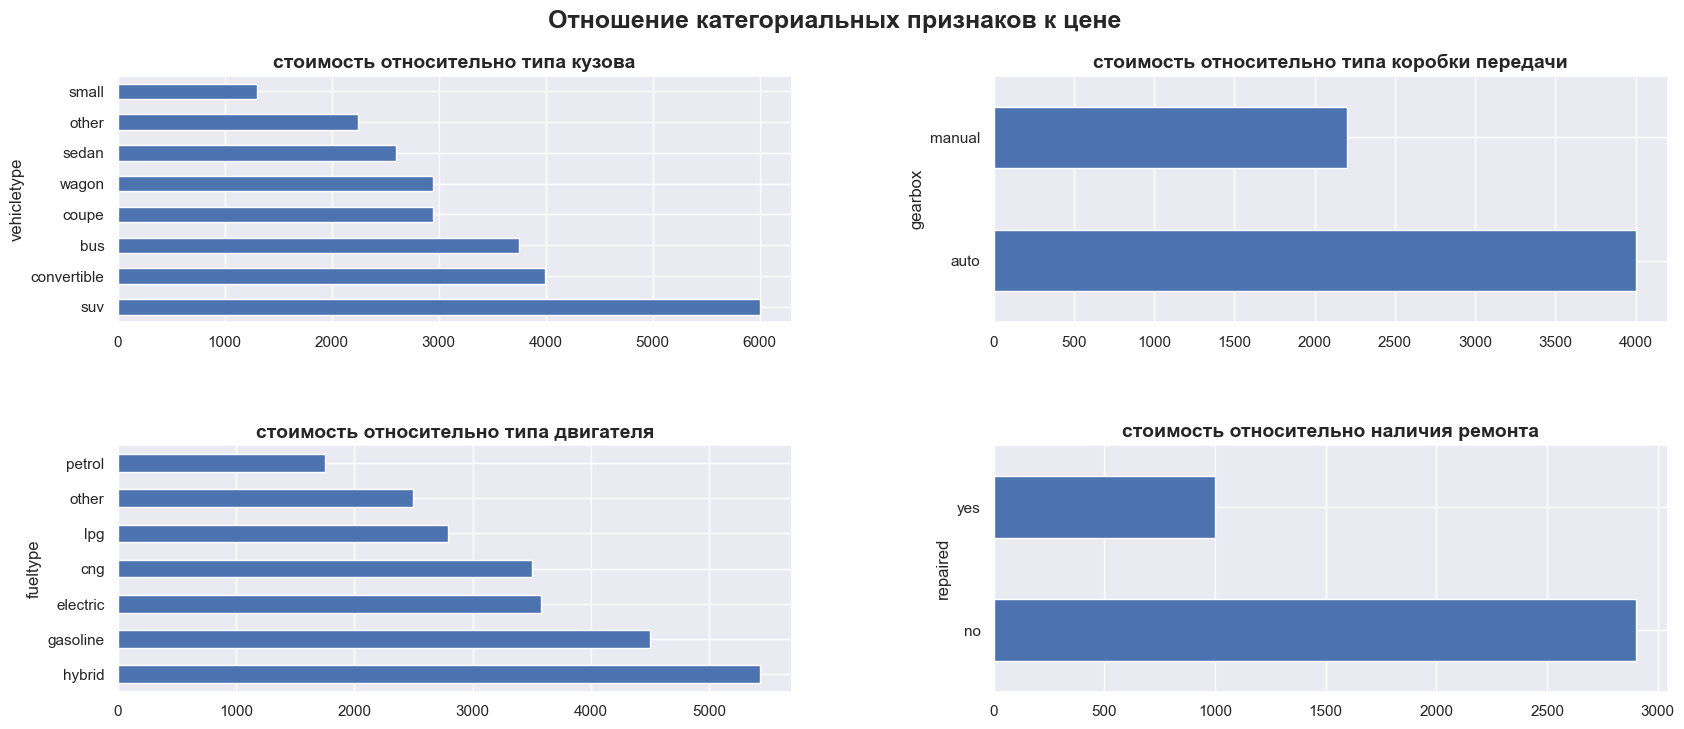

In [42]:
sns.set_theme()
fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.text(0.34, 0.94, 'Отношение категориальных признаков к цене', dict(fontweight='bold', fontsize=18));

data.groupby('vehicletype')['price'].agg('median').sort_values(ascending=False).plot(kind='barh', ax=ax, align='center') \
    .set_title(f'стоимость относительно типа кузова', dict(fontweight='bold', fontsize=14));
data.groupby('gearbox')['price'].agg('median').sort_values(ascending=False).plot(kind='barh', ax=ax1, align='center') \
    .set_title(f'стоимость относительно типа коробки передачи', dict(fontweight='bold', fontsize=14));
data.groupby('fueltype')['price'].agg('median').sort_values(ascending=False).plot(kind='barh', ax=ax2, align='center') \
    .set_title(f'стоимость относительно типа двигателя', dict(fontweight='bold', fontsize=14));
data.groupby('repaired')['price'].agg('median').sort_values(ascending=False).plot(kind='barh', ax=ax3, align='center') \
    .set_title(f'стоимость относительно наличия ремонта', dict(fontweight='bold', fontsize=14));

plt.show()

In [43]:
def group_featurs(featups, name):
    vehicletype_exam = data.groupby(featups)['price'].agg('median') \
        .plot(kind='barh',  align='center', figsize=(10,5)) \
        .set_title(f'стоимость относительно {name}', dict(fontweight='bold', fontsize=14));
    plt.show()

In [44]:
data['datecrawled'] = data['datecrawled'].dt.day
data['datecreated'] = data['datecreated'].dt.day
data['lastseen'] = data['lastseen'].dt.day

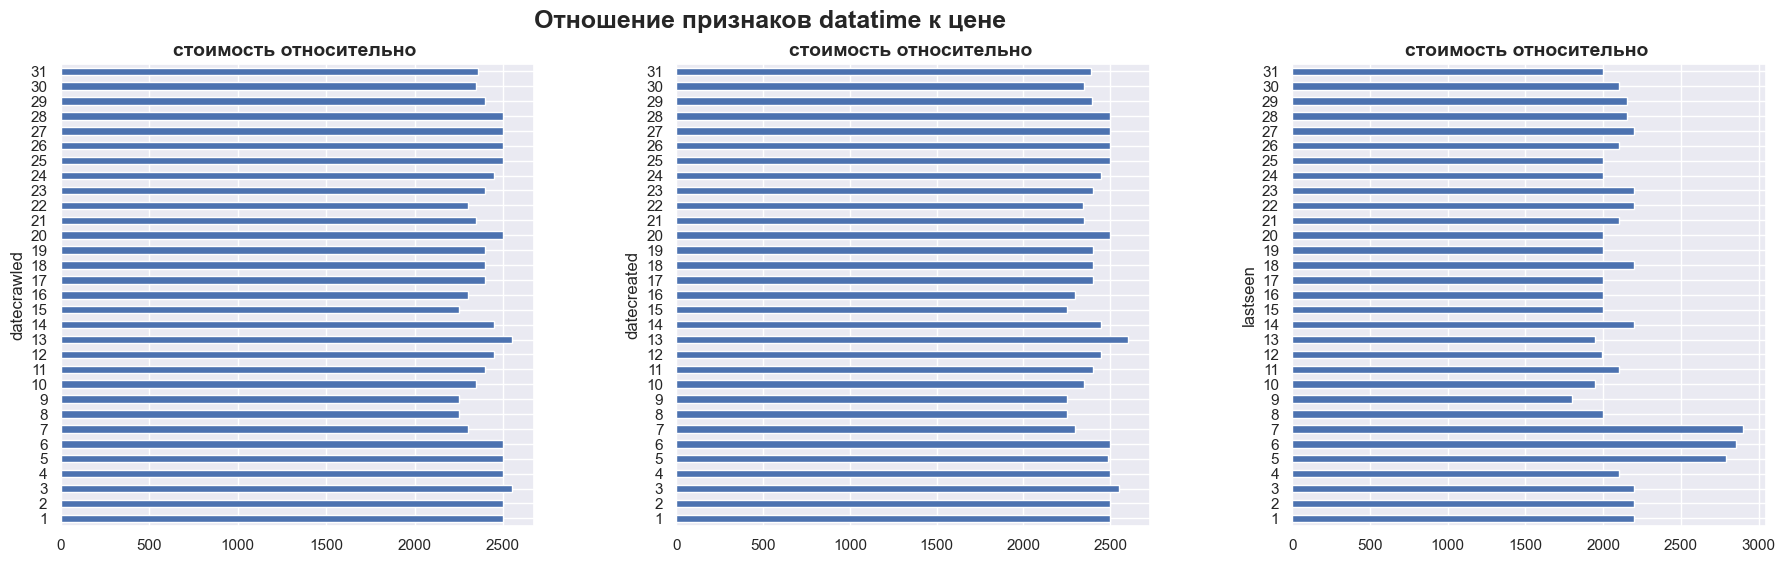

In [45]:
sns.set_theme()
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(22, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.text(0.34, 0.94, 'Отношение признаков datatime к цене', dict(fontweight='bold', fontsize=18));

data.groupby('datecrawled')['price'].agg('median').plot(kind='barh',  align='center', ax=ax) \
    .set_title(f'стоимость относительно ', dict(fontweight='bold', fontsize=14));
data.groupby('datecreated')['price'].agg('median').plot(kind='barh',  align='center', ax=ax1) \
    .set_title(f'стоимость относительно ', dict(fontweight='bold', fontsize=14));
data.groupby('lastseen')['price'].agg('median').plot(kind='barh',  align='center', ax=ax2) \
    .set_title(f'стоимость относительно ', dict(fontweight='bold', fontsize=14));


plt.show()

Признаки `datetime` не оказывают влияния на стоимость удалим их

In [46]:
data = data.drop(columns=['datecrawled', 'datecreated', 'lastseen'], axis=1)

Посмотрим есть ли связь между годом регистрации машины и историей ремонта

In [47]:
exam_repaire = data.copy()
exam_repaire['new_repaired'] = exam_repaire['repaired'].map({'yes': 'yes', 'no': 'no', np.nan: 'unknown'})
n = (exam_repaire['repaired']=='no').sum()
y = (exam_repaire['repaired']=='yes').sum()
u = exam_repaire['repaired'].isna().sum()
len_list_class_repair = [n, u, y]

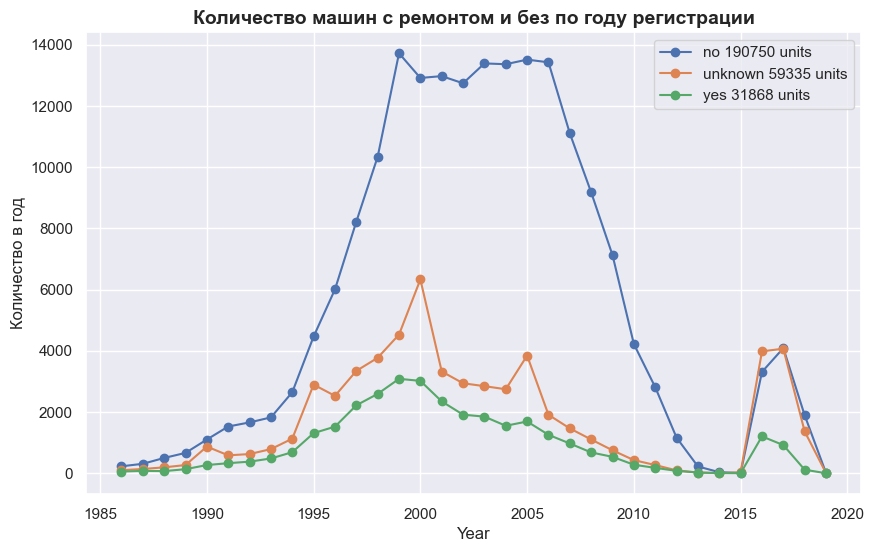

In [48]:

repai = exam_repaire.groupby(['registrationyear', 'new_repaired'])['repaired'].agg('size').reset_index()

groups = repai.groupby('new_repaired')
fig, ax = plt.subplots(figsize=(10, 6))
c = 0
for name, group in groups:
    ax.plot(group['registrationyear'], group['repaired'], marker='o', label=f'{name} {len_list_class_repair[c]} units')
    c += 1
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Количество в год')
ax.set_title('Количество машин с ремонтом и без по году регистрации', dict(fontweight='bold', fontsize=14))
plt.show()

Однозначно разделения нет и невозможно определить по году был ремонт у машины или не был<br>
Поставим заглушку на пропуски в категориальных признаках

In [49]:
data[object_columns] = data[object_columns].fillna('unknown')
display(data.describe(include=object))
display(data.describe(include=np.number))

,vehicletype,gearbox,model,fueltype,brand,repaired
count,281953,281953,281953,281953,281953,281953
unique,9,3,245,8,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,73394,220755,24497,168257,63858,190750


,price,registrationyear,power,kilometer
count,281953.000000,281953.000000,281953.000000,281953.000000
mean,3432.936149,2002.703060,116.661710,142662.269953
std,3090.749284,6.114641,41.762309,16138.263777
min,100.000000,1986.000000,50.000000,90000.000000
25%,1099.000000,1999.000000,86.000000,150000.000000
50%,2400.000000,2002.000000,108.000000,150000.000000
75%,4800.000000,2006.000000,143.000000,150000.000000
max,14295.000000,2019.000000,246.000000,150000.000000


Отлично заполнили пропуски и удалили мало значимые признаки<br>
Поделим на выборки<br>
Закодируем категориальные признаки<br>
И масштабируем числовые


In [50]:
signs = data.drop(columns='price', axis=1).copy()
target = data['price'].copy()
stratify = data['brand'].copy()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(signs, target, train_size=0.7, random_state=RANDOM_STATE, stratify=stratify)
stratify = X_test['brand'].copy()
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=RANDOM_STATE, stratify=stratify)

In [52]:
label_encoder = LabelEncoder()

for i in object_columns:
    label_encoder.fit(X_train[i])
    X_train[f'new_{i}'] = label_encoder.transform(X_train[i])
    X_valid[f'new_{i}'] = label_encoder.transform(X_valid[i])
    X_test[f'new_{i}'] = label_encoder.transform(X_test[i])

X_train = X_train.drop(columns=object_columns, axis=1)
X_valid = X_valid.drop(columns=object_columns, axis=1)
X_test = X_test.drop(columns=object_columns, axis=1)

In [53]:
numeric = ['registrationyear', 'power', 'kilometer']
scaler = StandardScaler().fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_valid.head()

,registrationyear,power,kilometer,new_vehicletype,new_gearbox,new_model,new_fueltype,new_brand,new_repaired
283222,0.210284,1.445205,0.455253,4,0,15,2,2,0
117839,0.210284,1.277504,0.455253,8,0,29,6,1,0
217117,2.333479,-0.159929,0.455253,7,1,114,2,38,1
22930,-0.279683,-0.998433,-1.093667,5,1,27,6,1,0
113220,0.046962,0.798360,0.455253,0,1,164,2,27,0


Подготовили данные обучим пару моделей

### Вывод

После пред-обработки данных из 16 изначальных признаков оставили 10 вместе с целевым <br>
Остальные удалили из-за их малого значения, удалили следующие признаки <br>
`DateCrawled, DateCreated, LastSeen, numberofpictures, postalcode, registrationmonth`<br>
Признак `power` и `price` обработали нулевые значения и малые значения заполнив их средним<br>
Сгруппированным по признаку `brend`, сравнили распределение признаков до и после заполнения <br>

Пропуски в 5 столбцах категориального типа `object` заполнили значение `unknown` <br>
Удалили выбросы в числовых данных используя размах ящика с усами<br>
Удалили 4 полных дубликата <br>

Построили графики для числовых признаков проверили распределение<br>
Распределения со сдвигами и несколькими пиками  <br>
Признак `price` имеет распределение с левым обрывом<br>

Рассмотрели корреляцию признаков с целевым признаком price по трём основным методам<br>
Присутствует корреляцию средней силы по Спирмену у признаков `registrationyear, power` с целевым<br>

Построили скаттер графики показывающие корреляцию признаков с целевым и удалили признаки<br>
`registrationmonth, postalcode` по результатам наблюдений<br>

Использовали `LabelEncoder библиотеки sklern` для кодирования категориальных признаков
И `StandardScaler` для масштабирования числовых признаков

## Обучение моделей

# LinearRegression

In [54]:

%%time
# optuna.logging.disable_default_handler()


def objective(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])
    copy_X = trial.suggest_categorical('copy_X', [True, False])

    model = LinearRegression(fit_intercept=fit_intercept, copy_X=copy_X)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    return mean_squared_error(y_valid, y_pred, squared=False)
LR_study = optuna.create_study(direction='minimize')
LR_study.optimize(objective, n_trials=8)
print(f"Best parameters: {LR_study.best_params}")
print(f"Best score: {LR_study.best_value:.2f}")

[I 2023-03-17 19:02:38,209] A new study created in memory with name: no-name-34cad6d1-ca23-4590-8ed7-af3ee40c9a85
[I 2023-03-17 19:02:38,275] Trial 0 finished with value: 2137.8842276842965 and parameters: {'fit_intercept': True, 'normalize': False, 'copy_X': False}. Best is trial 0 with value: 2137.8842276842965.
[I 2023-03-17 19:02:38,327] Trial 1 finished with value: 2137.8842276842965 and parameters: {'fit_intercept': True, 'normalize': True, 'copy_X': True}. Best is trial 0 with value: 2137.8842276842965.
[I 2023-03-17 19:02:38,374] Trial 2 finished with value: 2559.054734669714 and parameters: {'fit_intercept': False, 'normalize': False, 'copy_X': False}. Best is trial 0 with value: 2137.8842276842965.
[I 2023-03-17 19:02:38,424] Trial 3 finished with value: 2559.054734669714 and parameters: {'fit_intercept': False, 'normalize': True, 'copy_X': True}. Best is trial 0 with value: 2137.8842276842965.
[I 2023-03-17 19:02:38,482] Trial 4 finished with value: 2559.054734669714 and par

Best parameters: {'fit_intercept': True, 'normalize': False, 'copy_X': False}
Best score: 2137.88
CPU times: user 854 ms, sys: 80.1 ms, total: 934 ms
Wall time: 443 ms


# LightGBM

In [55]:
%%time

def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 80, 85),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.08794113388460592, 0.08794113389460592),
        'n_estimators': trial.suggest_int('n_estimators', 3300, 3310),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.22141662946848895, 0.22141662946868895),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.08986338849539488, 0.08986338849539888),
        'min_child_samples': trial.suggest_int('min_child_samples', 15, 20),
        'random_state': RANDOM_STATE
    }

    # Create the LGBMRegressor model with the sampled hyperparameters
    model = LGBMRegressor(**params)
    
    # Fit the model to the training data with early 
    model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=50,
              callbacks=[LightGBMPruningCallback(trial, 'rmse')])
    
    # Use the trained model to predict on the testing data
    y_pred = model.predict(X_valid)
    
    # Calculate the RMSE on the testing data
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
    # Return the RMSE as the objective value to be minimized by Optuna
    return rmse

# Create the Optuna study and run the optimization
LGBM_study = optuna.create_study(direction='minimize')
LGBM_study.optimize(objective, n_trials=10)

# Print best hyperparameters and best RMSE
print('Best hyperparameters: {}'.format(LGBM_study.best_params))
print('Best RMSE: {:.4f}'.format(LGBM_study.best_value))

[I 2023-03-17 19:02:38,661] A new study created in memory with name: no-name-bd7bff8c-1e20-4e97-a3c4-1d6f3a956796
/Users/maximlarin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-03-17 19:02:46,483] Trial 0 finished with value: 1313.6487710296265 and parameters: {'num_leaves': 83, 'learning_rate': 0.0879411338900659, 'n_estimators': 3304, 'reg_alpha': 0.22141662946857557, 'reg_lambda': 0.08986338849539754, 'min_child_samples': 17}. Best is trial 0 with value: 1313.6487710296265.


Best hyperparameters: {'num_leaves': 83, 'learning_rate': 0.0879411338900659, 'n_estimators': 3304, 'reg_alpha': 0.22141662946857557, 'reg_lambda': 0.08986338849539754, 'min_child_samples': 17}
Best RMSE: 1313.6488
CPU times: user 27.3 s, sys: 362 ms, total: 27.7 s
Wall time: 7.82 s


<h4>Блок ниже закомментирован для экономии времени <br> 
    Он был обсчитан на железе с использованием GPU <br> 
    Лучшие параметры найденные в нем послужили примерам<br> 
    Для составления усеченного списка из блока выше
    
    

In [56]:
# %%time

# def objective(trial):
#     # Define the hyperparameters to be tuned
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'device': 'gpu',
#         'num_leaves': trial.suggest_int('num_leaves', 2, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 5000),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'random_state': RANDOM_STATE
#     }
    
#     # Create the LGBMRegressor model with the sampled hyperparameters
#     model = LGBMRegressor(**params)
    
#     # Fit the model to the training data with early stopping and GPU pruning
#     model.fit(X_train, y_train, 
#               eval_set=[(X_valid, y_valid)],
#               early_stopping_rounds=50,
#               callbacks=[LightGBMPruningCallback(trial, 'rmse')])
    
#     # Use the trained model to predict on the testing data
#     y_pred = model.predict(X_valid)
    
#     # Calculate the RMSE on the testing data
#     rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
#     # Return the RMSE as the objective value to be minimized by Optuna
#     return rmse

# # Create the Optuna study and run the optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Print best hyperparameters and best RMSE
# print('Best hyperparameters: {}'.format(study.best_params))
# print('Best RMSE: {:.4f}'.format(study.best_value))

# Catboost

In [57]:
%%time
# Define objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 800, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.09893673514150166, 0.09893673514180166),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.10043417270317233, 0.10043417270357233),
        'random_strength': trial.suggest_loguniform('random_strength', 2.6251862551813288, 2.6251862551853288),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.013059768938083083, 0.013059768938086083)
    }
    
    # Train model with given hyperparameters
    model = CatBoostRegressor(**params, loss_function='RMSE',  random_seed=42)#  task_type='GPU',
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
    
    # Return RMSE
    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return rmse

# Run optimization
CB_study = optuna.create_study(direction='minimize')
CB_study.optimize(objective, n_trials=10)

# Print results
print('Best trial:')
trial = CB_study.best_trial
print('  Score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-03-17 19:02:46,503] A new study created in memory with name: no-name-a926ebab-32ca-4e23-bd36-07f9c73aa78e
[I 2023-03-17 19:03:27,795] Trial 0 finished with value: 1314.5660571623198 and parameters: {'iterations': 1868, 'learning_rate': 0.09893673514161805, 'depth': 10, 'l2_leaf_reg': 0.10043417270352098, 'random_strength': 2.625186255184763, 'bagging_temperature': 0.013059768938084209}. Best is trial 0 with value: 1314.5660571623198.


Best trial:
  Score: 1314.5660571623198
  Params: 
    iterations: 1868
    learning_rate: 0.09893673514161805
    depth: 10
    l2_leaf_reg: 0.10043417270352098
    random_strength: 2.625186255184763
    bagging_temperature: 0.013059768938084209
CPU times: user 1min 56s, sys: 2.12 s, total: 1min 58s
Wall time: 41.3 s


<h4>Блок ниже закомментирован для экономии времени <br> 
    Он был обсчитан на железе с использованием GPU <br> 
    Лучшие параметры найденные в нем послужили примерам<br> 
    Для составления усеченного списка из блока выше
    
    

In [58]:

# %%time
# # Define objective function for Optuna
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 5000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'depth': trial.suggest_int('depth', 1, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
#         'random_strength': trial.suggest_loguniform('random_strength', 0.1, 10.0),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00)
#     }
    
#     # Train model with given hyperparameters
#     model = CatBoostRegressor(**params, task_type='GPU', loss_function='RMSE', random_seed=42)
#     model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
    
#     # Return RMSE
#     y_pred = model.predict(X_valid)
#     rmse = mean_squared_error(y_valid, y_pred, squared=False)
#     return rmse

# # Run optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Print results
# print('Best trial:')
# trial = study.best_trial
# print('  Score: {}'.format(trial.value))
# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [59]:
best_result_rmse = {'LinearRegression':f'{LR_study.best_value:.2F}',
                   'LGBMRegressor': f'{LGBM_study.best_value:.2F}', 
                   'CatBoostRegressor': f'{CB_study.best_value:.2F}'}

best_result_rmse = pd.DataFrame([best_result_rmse], index=['best_scorr_rmse'])
best_result_rmse.T

,best_scorr_rmse
LinearRegression,2137.88
LGBMRegressor,1313.65
CatBoostRegressor,1314.57


### Вывод

Обучили и подобрали гиперпараметры для трёх моделей <br>
`LinearRegression, LGBMRegressor, CatBoostRegressor` <br>
Наименьшую ошибку RMSE показала модель `LGBMRegressor`  <br>

CatBoostRegressor и LGBMRegressor показали довольно близки результат<br>
Подготовим обученные модели обоих <br>
И проверим на тестовой выборке<br>


## Анализ моделей

Обучим модель CatBoostRegressor

In [60]:
model = CatBoostRegressor(**CB_study.best_params)#  task_type='GPU',
%time model.fit(X_train, y_train)
# **lgbm_cv_model.best_params_
# # Return RMSE
%time y_pred = model.predict(X_test)
CB_rmse = mean_squared_error(y_test, y_pred, squared=False)
CB_rmse

0:	learn: 2900.0816664	total: 26.7ms	remaining: 49.9s
1:	learn: 2725.6591314	total: 51.1ms	remaining: 47.6s
2:	learn: 2573.9666859	total: 80.8ms	remaining: 50.3s
3:	learn: 2444.4435638	total: 133ms	remaining: 1m 1s
4:	learn: 2333.0526966	total: 176ms	remaining: 1m 5s
5:	learn: 2235.3234205	total: 203ms	remaining: 1m 3s
6:	learn: 2148.5075146	total: 234ms	remaining: 1m 2s
7:	learn: 2072.1072177	total: 263ms	remaining: 1m 1s
8:	learn: 2001.3004917	total: 288ms	remaining: 59.5s
9:	learn: 1942.2007997	total: 316ms	remaining: 58.7s
10:	learn: 1886.1268113	total: 348ms	remaining: 58.7s
11:	learn: 1835.6025611	total: 377ms	remaining: 58.2s
12:	learn: 1792.9637471	total: 413ms	remaining: 59s
13:	learn: 1756.6591287	total: 453ms	remaining: 59.9s
14:	learn: 1727.5306225	total: 484ms	remaining: 59.7s
15:	learn: 1700.5973546	total: 511ms	remaining: 59.1s
16:	learn: 1674.3755211	total: 541ms	remaining: 58.9s
17:	learn: 1654.3168263	total: 567ms	remaining: 58.3s
18:	learn: 1634.7357606	total: 596ms	

154:	learn: 1338.5035267	total: 3.76s	remaining: 41.5s
155:	learn: 1338.1039635	total: 3.78s	remaining: 41.5s
156:	learn: 1337.4578578	total: 3.81s	remaining: 41.5s
157:	learn: 1336.9163001	total: 3.83s	remaining: 41.4s
158:	learn: 1336.1439020	total: 3.85s	remaining: 41.4s
159:	learn: 1335.2034364	total: 3.88s	remaining: 41.4s
160:	learn: 1334.2168168	total: 3.9s	remaining: 41.4s
161:	learn: 1333.6654597	total: 3.93s	remaining: 41.4s
162:	learn: 1333.1844580	total: 3.95s	remaining: 41.3s
163:	learn: 1332.7217527	total: 3.97s	remaining: 41.3s
164:	learn: 1332.3327793	total: 4s	remaining: 41.3s
165:	learn: 1331.8064551	total: 4.02s	remaining: 41.2s
166:	learn: 1331.2309848	total: 4.04s	remaining: 41.2s
167:	learn: 1330.2409856	total: 4.07s	remaining: 41.2s
168:	learn: 1329.8040336	total: 4.09s	remaining: 41.1s
169:	learn: 1329.2872047	total: 4.12s	remaining: 41.1s
170:	learn: 1328.6970227	total: 4.14s	remaining: 41.1s
171:	learn: 1328.2267518	total: 4.17s	remaining: 41.1s
172:	learn: 13

304:	learn: 1268.3399787	total: 7.29s	remaining: 37.3s
305:	learn: 1268.0150245	total: 7.3s	remaining: 37.3s
306:	learn: 1267.6495642	total: 7.33s	remaining: 37.3s
307:	learn: 1267.2707454	total: 7.35s	remaining: 37.2s
308:	learn: 1266.9902500	total: 7.37s	remaining: 37.2s
309:	learn: 1266.7919498	total: 7.39s	remaining: 37.1s
310:	learn: 1266.5230887	total: 7.41s	remaining: 37.1s
311:	learn: 1266.2591348	total: 7.43s	remaining: 37.1s
312:	learn: 1265.9603871	total: 7.46s	remaining: 37s
313:	learn: 1265.4352530	total: 7.48s	remaining: 37s
314:	learn: 1264.8230692	total: 7.5s	remaining: 37s
315:	learn: 1264.3966349	total: 7.52s	remaining: 36.9s
316:	learn: 1264.0203135	total: 7.54s	remaining: 36.9s
317:	learn: 1263.6443076	total: 7.56s	remaining: 36.9s
318:	learn: 1263.4226038	total: 7.58s	remaining: 36.8s
319:	learn: 1263.1572664	total: 7.61s	remaining: 36.8s
320:	learn: 1262.8662943	total: 7.63s	remaining: 36.8s
321:	learn: 1262.5618139	total: 7.65s	remaining: 36.7s
322:	learn: 1262.2

455:	learn: 1226.1565724	total: 10.7s	remaining: 33.1s
456:	learn: 1225.9111989	total: 10.7s	remaining: 33s
457:	learn: 1225.6013714	total: 10.7s	remaining: 33s
458:	learn: 1225.3387065	total: 10.7s	remaining: 33s
459:	learn: 1224.9740539	total: 10.8s	remaining: 32.9s
460:	learn: 1224.7699021	total: 10.8s	remaining: 32.9s
461:	learn: 1224.5893309	total: 10.8s	remaining: 32.9s
462:	learn: 1224.3676500	total: 10.8s	remaining: 32.8s
463:	learn: 1224.1208984	total: 10.8s	remaining: 32.8s
464:	learn: 1223.9877294	total: 10.9s	remaining: 32.8s
465:	learn: 1223.7958977	total: 10.9s	remaining: 32.8s
466:	learn: 1223.5284472	total: 10.9s	remaining: 32.8s
467:	learn: 1223.3308739	total: 10.9s	remaining: 32.7s
468:	learn: 1223.1243563	total: 11s	remaining: 32.7s
469:	learn: 1223.0100663	total: 11s	remaining: 32.7s
470:	learn: 1222.7371536	total: 11s	remaining: 32.7s
471:	learn: 1222.4782499	total: 11.1s	remaining: 32.7s
472:	learn: 1222.3448642	total: 11.1s	remaining: 32.7s
473:	learn: 1222.18478

610:	learn: 1195.5463987	total: 14.2s	remaining: 29.3s
611:	learn: 1195.4215568	total: 14.2s	remaining: 29.2s
612:	learn: 1195.2924520	total: 14.3s	remaining: 29.2s
613:	learn: 1195.2399751	total: 14.3s	remaining: 29.2s
614:	learn: 1195.1133638	total: 14.3s	remaining: 29.2s
615:	learn: 1194.9264886	total: 14.3s	remaining: 29.2s
616:	learn: 1194.7942121	total: 14.4s	remaining: 29.1s
617:	learn: 1194.6873810	total: 14.4s	remaining: 29.1s
618:	learn: 1194.4384406	total: 14.4s	remaining: 29.1s
619:	learn: 1194.2752028	total: 14.4s	remaining: 29.1s
620:	learn: 1194.0320595	total: 14.5s	remaining: 29s
621:	learn: 1193.8969402	total: 14.5s	remaining: 29s
622:	learn: 1193.8123511	total: 14.5s	remaining: 29s
623:	learn: 1193.6199081	total: 14.5s	remaining: 29s
624:	learn: 1193.3936289	total: 14.6s	remaining: 29s
625:	learn: 1193.2326905	total: 14.6s	remaining: 28.9s
626:	learn: 1193.0612136	total: 14.6s	remaining: 28.9s
627:	learn: 1192.9502328	total: 14.6s	remaining: 28.9s
628:	learn: 1192.840

761:	learn: 1173.1991581	total: 18.1s	remaining: 26.3s
762:	learn: 1173.0729956	total: 18.1s	remaining: 26.3s
763:	learn: 1172.8492542	total: 18.2s	remaining: 26.3s
764:	learn: 1172.7722648	total: 18.2s	remaining: 26.2s
765:	learn: 1172.5800265	total: 18.2s	remaining: 26.2s
766:	learn: 1172.4780965	total: 18.2s	remaining: 26.2s
767:	learn: 1172.3307170	total: 18.3s	remaining: 26.2s
768:	learn: 1172.1772105	total: 18.3s	remaining: 26.1s
769:	learn: 1172.0922201	total: 18.3s	remaining: 26.1s
770:	learn: 1172.0224826	total: 18.3s	remaining: 26.1s
771:	learn: 1171.8908123	total: 18.4s	remaining: 26.1s
772:	learn: 1171.8261394	total: 18.4s	remaining: 26.1s
773:	learn: 1171.7392106	total: 18.4s	remaining: 26s
774:	learn: 1171.5529834	total: 18.4s	remaining: 26s
775:	learn: 1171.4485849	total: 18.5s	remaining: 26s
776:	learn: 1171.3579585	total: 18.5s	remaining: 26s
777:	learn: 1171.2249579	total: 18.5s	remaining: 26s
778:	learn: 1171.1041627	total: 18.6s	remaining: 25.9s
779:	learn: 1170.927

913:	learn: 1153.5060674	total: 22s	remaining: 22.9s
914:	learn: 1153.4282361	total: 22s	remaining: 22.9s
915:	learn: 1153.3347294	total: 22s	remaining: 22.9s
916:	learn: 1153.2764844	total: 22s	remaining: 22.8s
917:	learn: 1153.1165592	total: 22.1s	remaining: 22.8s
918:	learn: 1153.0285131	total: 22.1s	remaining: 22.8s
919:	learn: 1152.9492324	total: 22.1s	remaining: 22.8s
920:	learn: 1152.8497921	total: 22.1s	remaining: 22.7s
921:	learn: 1152.7644352	total: 22.1s	remaining: 22.7s
922:	learn: 1152.6507858	total: 22.2s	remaining: 22.7s
923:	learn: 1152.5586885	total: 22.2s	remaining: 22.7s
924:	learn: 1152.4492234	total: 22.2s	remaining: 22.6s
925:	learn: 1152.3781719	total: 22.2s	remaining: 22.6s
926:	learn: 1152.3170735	total: 22.2s	remaining: 22.6s
927:	learn: 1152.1434941	total: 22.3s	remaining: 22.6s
928:	learn: 1151.9988834	total: 22.3s	remaining: 22.5s
929:	learn: 1151.8683602	total: 22.3s	remaining: 22.5s
930:	learn: 1151.7622693	total: 22.3s	remaining: 22.5s
931:	learn: 1151.6

1064:	learn: 1137.1571968	total: 25.8s	remaining: 19.5s
1065:	learn: 1137.0294231	total: 25.9s	remaining: 19.4s
1066:	learn: 1136.8874973	total: 25.9s	remaining: 19.4s
1067:	learn: 1136.8128051	total: 25.9s	remaining: 19.4s
1068:	learn: 1136.7171081	total: 25.9s	remaining: 19.4s
1069:	learn: 1136.5838062	total: 26s	remaining: 19.4s
1070:	learn: 1136.5157161	total: 26s	remaining: 19.3s
1071:	learn: 1136.4327965	total: 26s	remaining: 19.3s
1072:	learn: 1136.3354801	total: 26s	remaining: 19.3s
1073:	learn: 1136.2667728	total: 26.1s	remaining: 19.3s
1074:	learn: 1136.1052029	total: 26.1s	remaining: 19.2s
1075:	learn: 1135.9965657	total: 26.1s	remaining: 19.2s
1076:	learn: 1135.9338383	total: 26.1s	remaining: 19.2s
1077:	learn: 1135.8769714	total: 26.2s	remaining: 19.2s
1078:	learn: 1135.8340796	total: 26.2s	remaining: 19.1s
1079:	learn: 1135.7809181	total: 26.2s	remaining: 19.1s
1080:	learn: 1135.7009347	total: 26.2s	remaining: 19.1s
1081:	learn: 1135.5407073	total: 26.2s	remaining: 19.1s


1215:	learn: 1122.7634357	total: 29.1s	remaining: 15.6s
1216:	learn: 1122.6909088	total: 29.1s	remaining: 15.6s
1217:	learn: 1122.6054427	total: 29.1s	remaining: 15.5s
1218:	learn: 1122.5361938	total: 29.1s	remaining: 15.5s
1219:	learn: 1122.4293219	total: 29.1s	remaining: 15.5s
1220:	learn: 1122.3397904	total: 29.2s	remaining: 15.4s
1221:	learn: 1122.2681056	total: 29.2s	remaining: 15.4s
1222:	learn: 1122.1709787	total: 29.2s	remaining: 15.4s
1223:	learn: 1122.0924744	total: 29.2s	remaining: 15.4s
1224:	learn: 1121.9894253	total: 29.2s	remaining: 15.3s
1225:	learn: 1121.8960001	total: 29.2s	remaining: 15.3s
1226:	learn: 1121.8485587	total: 29.3s	remaining: 15.3s
1227:	learn: 1121.7651276	total: 29.3s	remaining: 15.3s
1228:	learn: 1121.7045611	total: 29.3s	remaining: 15.2s
1229:	learn: 1121.6439819	total: 29.3s	remaining: 15.2s
1230:	learn: 1121.5158743	total: 29.3s	remaining: 15.2s
1231:	learn: 1121.4049633	total: 29.4s	remaining: 15.2s
1232:	learn: 1121.3224043	total: 29.4s	remaining

1368:	learn: 1109.4530503	total: 32.2s	remaining: 11.7s
1369:	learn: 1109.3248677	total: 32.2s	remaining: 11.7s
1370:	learn: 1109.1897456	total: 32.3s	remaining: 11.7s
1371:	learn: 1109.1297652	total: 32.3s	remaining: 11.7s
1372:	learn: 1109.0755524	total: 32.3s	remaining: 11.6s
1373:	learn: 1108.9784290	total: 32.3s	remaining: 11.6s
1374:	learn: 1108.8544921	total: 32.4s	remaining: 11.6s
1375:	learn: 1108.7212462	total: 32.4s	remaining: 11.6s
1376:	learn: 1108.6551142	total: 32.4s	remaining: 11.6s
1377:	learn: 1108.5080456	total: 32.4s	remaining: 11.5s
1378:	learn: 1108.4562059	total: 32.5s	remaining: 11.5s
1379:	learn: 1108.3740384	total: 32.5s	remaining: 11.5s
1380:	learn: 1108.3453847	total: 32.5s	remaining: 11.5s
1381:	learn: 1108.3022983	total: 32.5s	remaining: 11.4s
1382:	learn: 1108.2564606	total: 32.5s	remaining: 11.4s
1383:	learn: 1108.1870670	total: 32.6s	remaining: 11.4s
1384:	learn: 1108.0726036	total: 32.6s	remaining: 11.4s
1385:	learn: 1108.0043969	total: 32.6s	remaining

1519:	learn: 1097.5121811	total: 35.4s	remaining: 8.11s
1520:	learn: 1097.4656612	total: 35.4s	remaining: 8.08s
1521:	learn: 1097.4210504	total: 35.4s	remaining: 8.06s
1522:	learn: 1097.3045562	total: 35.5s	remaining: 8.03s
1523:	learn: 1097.2251416	total: 35.5s	remaining: 8.01s
1524:	learn: 1097.1839478	total: 35.5s	remaining: 7.99s
1525:	learn: 1097.1043528	total: 35.5s	remaining: 7.96s
1526:	learn: 1096.9812987	total: 35.6s	remaining: 7.94s
1527:	learn: 1096.8422852	total: 35.6s	remaining: 7.92s
1528:	learn: 1096.7846148	total: 35.6s	remaining: 7.9s
1529:	learn: 1096.6752923	total: 35.6s	remaining: 7.87s
1530:	learn: 1096.5342409	total: 35.7s	remaining: 7.85s
1531:	learn: 1096.4826146	total: 35.7s	remaining: 7.83s
1532:	learn: 1096.3955120	total: 35.7s	remaining: 7.8s
1533:	learn: 1096.3349658	total: 35.7s	remaining: 7.78s
1534:	learn: 1096.2593139	total: 35.7s	remaining: 7.75s
1535:	learn: 1096.1826388	total: 35.8s	remaining: 7.73s
1536:	learn: 1096.1308944	total: 35.8s	remaining: 

1674:	learn: 1086.3642110	total: 38.3s	remaining: 4.42s
1675:	learn: 1086.2751103	total: 38.3s	remaining: 4.39s
1676:	learn: 1086.2132157	total: 38.4s	remaining: 4.37s
1677:	learn: 1086.1335481	total: 38.4s	remaining: 4.35s
1678:	learn: 1086.0633817	total: 38.4s	remaining: 4.32s
1679:	learn: 1086.0149206	total: 38.4s	remaining: 4.3s
1680:	learn: 1085.9635475	total: 38.4s	remaining: 4.28s
1681:	learn: 1085.8920052	total: 38.5s	remaining: 4.25s
1682:	learn: 1085.8532877	total: 38.5s	remaining: 4.23s
1683:	learn: 1085.7856455	total: 38.5s	remaining: 4.21s
1684:	learn: 1085.7366699	total: 38.5s	remaining: 4.18s
1685:	learn: 1085.7022855	total: 38.5s	remaining: 4.16s
1686:	learn: 1085.5814678	total: 38.5s	remaining: 4.13s
1687:	learn: 1085.5180467	total: 38.6s	remaining: 4.11s
1688:	learn: 1085.4544922	total: 38.6s	remaining: 4.09s
1689:	learn: 1085.4129576	total: 38.6s	remaining: 4.07s
1690:	learn: 1085.3732606	total: 38.6s	remaining: 4.04s
1691:	learn: 1085.2764926	total: 38.6s	remaining:

1832:	learn: 1075.5698211	total: 41.3s	remaining: 788ms
1833:	learn: 1075.5170928	total: 41.3s	remaining: 765ms
1834:	learn: 1075.4443051	total: 41.3s	remaining: 743ms
1835:	learn: 1075.4101568	total: 41.3s	remaining: 720ms
1836:	learn: 1075.3541504	total: 41.3s	remaining: 698ms
1837:	learn: 1075.3284763	total: 41.4s	remaining: 675ms
1838:	learn: 1075.2627364	total: 41.4s	remaining: 653ms
1839:	learn: 1075.2349699	total: 41.4s	remaining: 630ms
1840:	learn: 1075.1811365	total: 41.4s	remaining: 607ms
1841:	learn: 1075.0772300	total: 41.4s	remaining: 585ms
1842:	learn: 1075.0208550	total: 41.5s	remaining: 562ms
1843:	learn: 1074.9492089	total: 41.5s	remaining: 540ms
1844:	learn: 1074.9147510	total: 41.5s	remaining: 517ms
1845:	learn: 1074.8705139	total: 41.5s	remaining: 495ms
1846:	learn: 1074.8156884	total: 41.5s	remaining: 472ms
1847:	learn: 1074.7708399	total: 41.5s	remaining: 450ms
1848:	learn: 1074.7220134	total: 41.6s	remaining: 427ms
1849:	learn: 1074.6609501	total: 41.6s	remaining

Обучим модель LGBMRegressor

In [ ]:
LGBM_model = LGBMRegressor(**LGBM_study.best_params)#  task_type='GPU',
%time LGBM_model.fit(X_train, y_train)
# **lgbm_cv_model.best_params_
# # Return RMSE
%time y_pred = LGBM_model.predict(X_test)
LGBM_rmse = mean_squared_error(y_test, y_pred, squared=False)
LGBM_rmse

**Ошибка RMSE CatBoostRegressor на тестовых данных  `1307.3670330187433`**<BR>
Время потраченное на поиск лучших гипер-параметров модели CatBoostRegressor с малым количеством перебора<BR>
И без использования GPU составило 15min 16s<BR>
Обучение модели CatBoostRegressor заняло 2min 21s<BR>
Расчет предсказания составил 330 ms<BR>


**Ошибка RMSE LGBMRegressor на тестовых данных  `1309.228717034512`**<BR>
Время потраченное на поиск лучших гипер-параметров модели LGBMRegressor с малым количеством перебора<BR>
И без использования GPU составило 3min 13s<BR>
Обучение модели CatBoostRegressor заняло 1min 5s<BR>
Расчет предсказания составил 12.2 s<BR>



### Вывод
Несмотря на то, что на валидационных данных ошибка RMSE модели CatBoostRegressor <br>
Была немного хуже, на тестовых данных она показала лучший результат<br>
Соответственно противоположная ситуация произошла с моделью LGBMRegressor<br>

На данном этапе обе модели подходят для использования<br>
Необходимо провести тестирование на большем объёме данных и собрать больше информации для финального выбора<br>

Также можно отметить, что время подбора гипер-параметров ощутимо больше времени обучения<br>



## Вывод финал 
Для сервиса не «Не бит, не крашен» разработали две модели удовлетворяющих требованиям <br>
* модель CatBoostRegressor со значением RMSE 1307.3670
* модель LGBMRegressor со значением RMSE 1309.2287

В процессе разработки и подготовки данных удалили признаки
DateCrawled, DateCreated, LastSeen, numberofpictures, postalcode, registrationmonth
Оставив признаки 
registrationyear, power, kilometer, vehicletype,
gearbox, model, fueltype, brand, repaired
Пропуски в 5 столбцах категориального типа `object` заполнили значение `unknown` <br>
Удалили выбросы в числовых данных используя размах ящика с усами<br>
Удалили 4 полных дубликата которые мы удалим незамедлительно<br>

Построили графики для числовых признаков проверили распределение<br>
Распределения со сдвигами и несколькими пиками  <br>
Признак `price` имеет распределение с левым обрывом<br>

Построили скаттер графики показывающие корреляцию признаков с целевым<br>
Удалили признаки`registrationmonth, postalcode` по результатам наблюдений<br>

Использовали `LabelEncoder библиотеки sklern` для кодирования категориальных признаков
И `StandardScaler` для масштабирования числовых признаков

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей